In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
# Emotions we want recognize
emotion_table = {0: 'neutral',
                 1: 'happiness',
                 2: 'surprise',
                 3: 'sadness',
                 4: 'anger',
                 5: 'disgust',
                 6: 'fear',
                 7: 'contempt'}

In [3]:
processed_train_images = np.load('./data/fer_train_processed_images.npy')
processed_train_labels = np.load('./data/fer_train_processed_labels.npy')

In [4]:
print(processed_train_images.shape, processed_train_labels.shape)

(25045, 1, 64, 64) (25045, 8)


In [5]:
from matplotlib import pyplot as plt

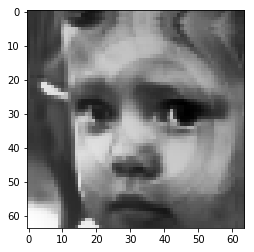

In [6]:
plt.imshow(processed_train_images[987].reshape(64,64), cmap='gray')

In [7]:
processed_test_images = np.load('./data/fer_test_processed_images.npy')
processed_test_labels = np.load('./data/fer_test_processed_labels.npy')
processed_val_images = np.load('./data/fer_val_processed_images.npy')
processed_val_labels = np.load('./data/fer_val_processed_labels.npy')

In [8]:
print(processed_test_images.shape, processed_test_labels.shape)

(3137, 1, 64, 64) (3137, 8)


In [9]:
print(processed_val_images.shape, processed_val_labels.shape)

(3191, 1, 64, 64) (3191, 8)


In [10]:
# Set this to ctx = mx.cpu() if running on CPU. 
# However, please note, it takes approx. 1.1 min/epoch on 1 GPU => Can take longer time on cPU

ctx = mx.gpu()

In [11]:
# We use HybridSequential network type to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net = gluon.nn.HybridSequential()

# Construct 13 layer VGGNet suggested in the paper
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    net.add(gluon.nn.Dropout(0.25))
    
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(1024, activation='relu'))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(8))

In [12]:
# We Hybridize the HybridSequential network to able to save the trained model as symbols and params.
# More Info - https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
net.hybridize()

In [13]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
nd.waitall()

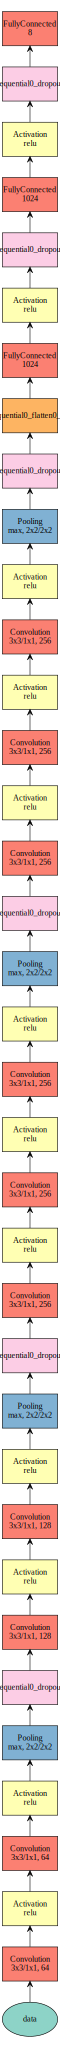

In [14]:
# Use MXBOARD here to visualize network
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)


In [15]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [16]:
batch_size = 32
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.0025, 'momentum': 0.9})

In [17]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [18]:
train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_train_images, train_labels), batch_size = batch_size, shuffle=True)
val_data = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_val_images, val_labels), batch_size = batch_size)

In [19]:
epochs = 25

train_accuracies = []
losses = []
val_accuracies = []

for e in range(epochs):
    batch = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
        batch +=1        

    val_accuracy = evaluate_accuracy(val_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    
    losses.append(curr_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print("Epoch %s. Loss: %s, Train_acc %s, Val_acc %s" % (e, curr_loss, train_accuracy, val_accuracy))

Epoch 0. Loss: 1.31065, Train_acc 0.348692353763, Val_acc 0.369790034472
Epoch 1. Loss: 1.53128, Train_acc 0.362587342783, Val_acc 0.389533061736
Epoch 2. Loss: 1.67258, Train_acc 0.425633859054, Val_acc 0.444688185522
Epoch 3. Loss: 1.69161, Train_acc 0.479936114993, Val_acc 0.495769351301
Epoch 4. Loss: 1.44702, Train_acc 0.525813535636, Val_acc 0.542149796302
Epoch 5. Loss: 1.39918, Train_acc 0.583070473148, Val_acc 0.599185208399
Epoch 6. Loss: 0.99135, Train_acc 0.62838889998, Val_acc 0.637731118772
Epoch 7. Loss: 1.12209, Train_acc 0.667278897984, Val_acc 0.676277029144
Epoch 8. Loss: 1.01877, Train_acc 0.676662008385, Val_acc 0.693513005327
Epoch 9. Loss: 0.936635, Train_acc 0.722100219605, Val_acc 0.726104669383
Epoch 10. Loss: 0.86835, Train_acc 0.73184268317, Val_acc 0.729865246004
Epoch 11. Loss: 0.389315, Train_acc 0.748093431823, Val_acc 0.733625822626
Epoch 12. Loss: 0.342252, Train_acc 0.767418646436, Val_acc 0.742087120025
Epoch 13. Loss: 1.06354, Train_acc 0.7801557197

In [20]:
# Test accuracy

acc = mx.metric.Accuracy()
test_labels = np.argmax(processed_test_labels, axis=1)
data_iterator = gluon.data.DataLoader(gluon.data.ArrayDataset(processed_test_images, test_labels), batch_size = 32)
for i, (data, label) in enumerate(data_iterator):
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    acc.update(preds=predictions, labels=label)
print("Test Accuracy - ", acc.get()[1])

Test Accuracy -  0.798214854957


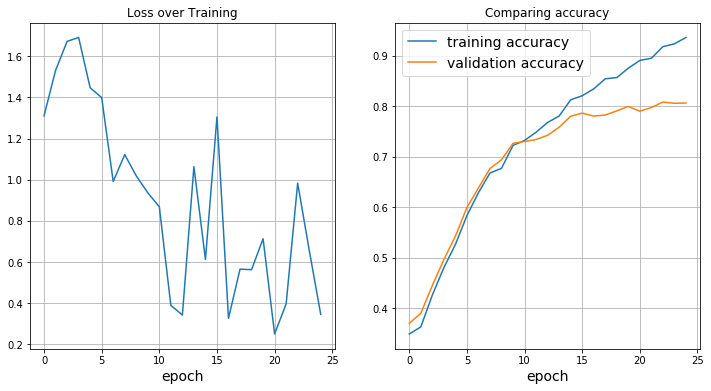

In [21]:
# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

epochs = range(len(train_accuracies))

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(epochs, losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(epochs, train_accuracies)
p2, = fg2.plot(epochs, val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)

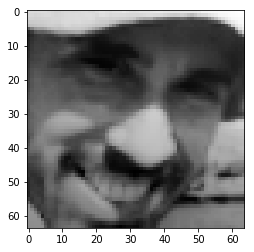

In [22]:
# Example Inference
idx = 139
plt.imshow(processed_test_images[idx].reshape(64,64), cmap='gray')

In [23]:
print("Actual Emotion - ", emotion_table[test_labels[idx]])

Actual Emotion -  happiness


In [24]:
# Perform Inference
output = net(mx.nd.array(processed_test_images[idx].reshape(1,1,64,64)).as_in_context(ctx))

In [25]:
print("Predicted Emotion - ", emotion_table[nd.argmax(output, axis=1).asnumpy()[0]])

Predicted Emotion -  happiness


In [27]:
# Export the model for production deployment.
# There will be 2 files exported: 
# 1) gluon_ferplus-symbol.json => Contains the network definition
# 2) gluon_ferplus-0000.params => Contains the weights in the network
net.export('gluon_ferplus')